c:\Users\e5750482\InnovateIN48\DARSHAN\Hariharan\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 29s 915ms/step - loss: 0.1069
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 25s 875ms/step - loss: 0.0022
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 25s 880ms/step - loss: 0.0013
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - loss: 6.9914e-04   
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - loss: 3.4805e-04
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - loss: 2.2508e-04
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - loss: 2.1870e-04
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - loss: 2.3351e-04
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - loss: 2.5331e-04
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - loss: 2.1520e-04
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - loss: 2.1957e-04
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - loss: 2.1263e-04
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - loss: 2.0860e-04
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - loss: 2.0957e-04
Epoch 15/100
28

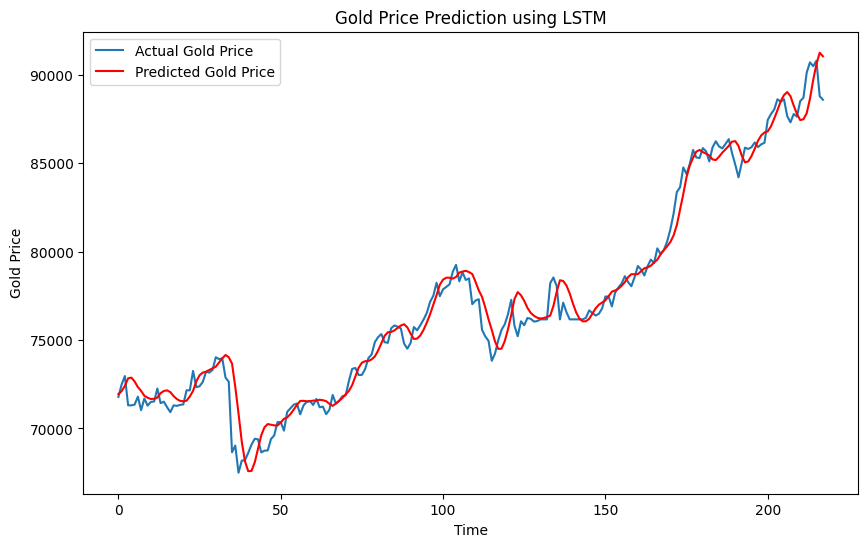

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv("Gold.csv")

# Extract the date and closing price
data['Date'] = pd.to_datetime(data['Date'])
data= data.sort_values(by='Date', ascending=True)  # Sort by Date in ascending order
data=data.reset_index()

# Extract only the 'Price' column for prediction
gold_price = data['Price'].values

# Normalize the data (scaling it between 0 and 1)
scaler = MinMaxScaler(feature_range=(0, 1))
gold_price_scaled = scaler.fit_transform(gold_price.reshape(-1, 1))

# Define the time step for sequences (using 5 years = 5 * 365 days)
time_step = 5 * 365

# Prepare the dataset for training (X: input, y: target)
X = []
y = []

for i in range(time_step, len(gold_price_scaled)):
    X.append(gold_price_scaled[i - time_step:i, 0])  # last 5 years
    y.append(gold_price_scaled[i, 0])  # next year's price

X = np.array(X)
y = np.array(y)

# Reshape X to be 3D [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()

# LSTM layer (use return_sequences=True to stack multiple LSTM layers)
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))  # Output layer for the predicted price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Predict the next year's price using the test data
predictions_scaled = model.predict(X_test)

# Inverse transform the predictions and actual values
predictions = scaler.inverse_transform(predictions_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate the prediction errors
mae = mean_absolute_error(y_test_actual, predictions)
mse = mean_squared_error(y_test_actual, predictions)
rmse = np.sqrt(mse)

# Display the errors
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual Gold Price')
plt.plot(predictions, label='Predicted Gold Price', color='red')
plt.title('Gold Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Gold Price')
plt.legend()
plt.show()


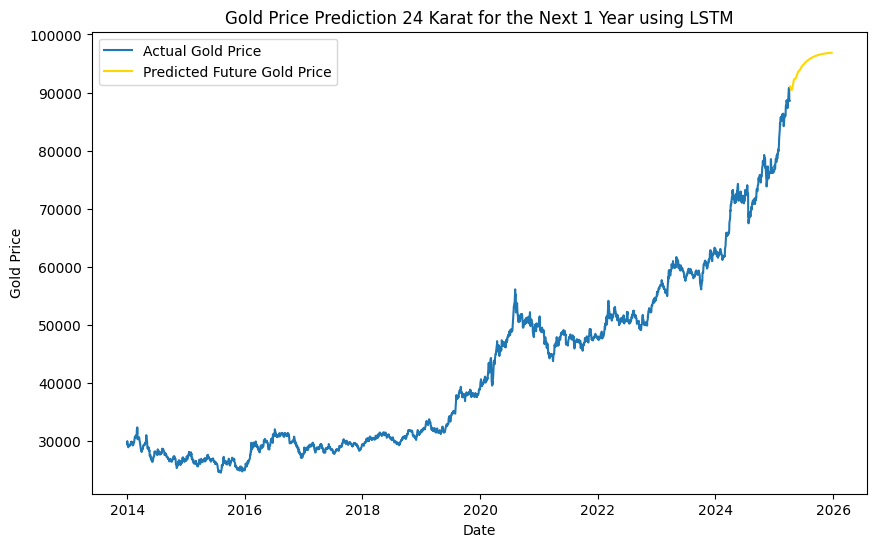

In [8]:
import tensorflow as tf
#uncomment below line for loading already saved model
#model = tf.keras.models.load_model('LSTM.h5') 
# Predict the next 1 year of gold prices (260 days)
future_days = 260

# Start by using the last 1 year of data as input
last_known_data = X[-1].reshape(1, time_step, 1)

# List to store the predictions for the next 1 year
future_predictions = []

for _ in range(future_days):
    # Predict the next day's gold price
    predicted_price = model.predict(last_known_data,verbose=0)
    
    # Append the predicted price to the future predictions list
    future_predictions.append(predicted_price[0][0])
    
    # Update the input for the next prediction: add the predicted price to the sequence
    last_known_data = np.append(last_known_data[:, 1:, :], predicted_price.reshape(1, 1, 1), axis=1)

# Inverse transform the predictions back to the original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Generate corresponding dates for the next 5 years
last_date = data['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date, periods=future_days + 1, freq='D')[1:]

# Plot the actual prices and the predicted future prices
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], gold_price, label='Actual Gold Price')
plt.plot(future_dates, future_predictions, label='Predicted Future Gold Price', color='gold')
plt.title('Gold Price Prediction 24 Karat for the Next 1 Year using LSTM')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend()
plt.show()


In [9]:
# Create a DataFrame with future_dates and future_predictions
predictions_df = pd.DataFrame({
    "Date": future_dates,
    "Price": future_predictions.flatten()
})

# Save the DataFrame to a CSV file
predictions_df.to_csv("future_gold_predictions.csv", index=False)


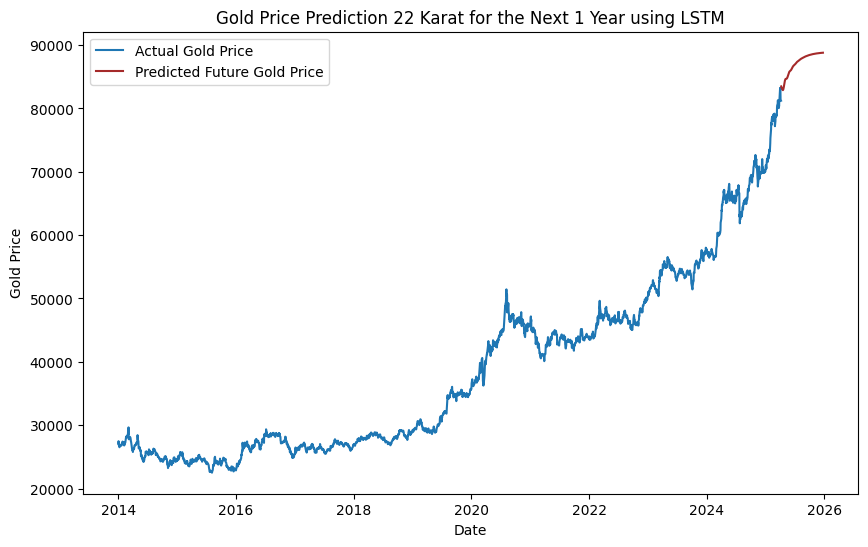

In [4]:
CONVERSION_FACTOR=0.9167
import tensorflow as tf
#uncomment below line for loading already saved model
#model = tf.keras.models.load_model('LSTM.h5') 
# Predict the next 1 year of gold prices (260 days)
future_days = 260

# Start by using the last 5 years of data as input
last_known_data = X[-1].reshape(1, time_step, 1)

# List to store the predictions for the next 1 year
future_predictions = []

for _ in range(future_days):
    # Predict the next day's gold price
    predicted_price = model.predict(last_known_data,verbose=0)
    
    # Append the predicted price to the future predictions list
    future_predictions.append(predicted_price[0][0])
    
    # Update the input for the next prediction: add the predicted price to the sequence
    last_known_data = np.append(last_known_data[:, 1:, :], predicted_price.reshape(1, 1, 1), axis=1)

# Inverse transform the predictions back to the original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Generate corresponding dates for the next 5 years
last_date = data['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date, periods=future_days + 1, freq='D')[1:]

# Plot the actual prices and the predicted future prices
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], gold_price*CONVERSION_FACTOR, label='Actual Gold Price')
plt.plot(future_dates, future_predictions*CONVERSION_FACTOR, label='Predicted Future Gold Price', color='brown')
plt.title('Gold Price Prediction 22 Karat for the Next 1 Year using LSTM')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend()
plt.show()


In [5]:
print(future_predictions)

[[91061.62 ]
 [90943.18 ]
 [90869.56 ]
 [90811.52 ]
 [90752.266]
 [90685.63 ]
 [90613.54 ]
 [90542.5  ]
 [90480.96 ]
 [90437.21 ]
 [90418.24 ]
 [90428.94 ]
 [90471.87 ]
 [90547.21 ]
 [90652.96 ]
 [90785.24 ]
 [90938.69 ]
 [91106.9  ]
 [91282.945]
 [91459.84 ]
 [91630.96 ]
 [91790.48 ]
 [91933.66 ]
 [92057.09 ]
 [92158.83 ]
 [92238.35 ]
 [92296.586]
 [92335.7  ]
 [92358.9  ]
 [92370.1  ]
 [92373.69 ]
 [92374.14 ]
 [92375.85 ]
 [92382.67 ]
 [92397.9  ]
 [92423.92 ]
 [92462.28 ]
 [92513.57 ]
 [92577.38 ]
 [92652.586]
 [92737.29 ]
 [92829.1  ]
 [92925.3  ]
 [93022.98 ]
 [93119.31 ]
 [93211.766]
 [93298.11 ]
 [93376.625]
 [93446.22 ]
 [93506.38 ]
 [93557.164]
 [93599.266]
 [93633.766]
 [93662.21 ]
 [93686.305]
 [93707.94 ]
 [93728.97 ]
 [93751.14 ]
 [93775.96 ]
 [93804.59 ]
 [93837.9  ]
 [93876.27 ]
 [93919.766]
 [93968.016]
 [94020.4  ]
 [94075.95 ]
 [94133.56 ]
 [94192.08 ]
 [94250.24 ]
 [94306.91 ]
 [94361.07 ]
 [94411.93 ]
 [94458.9  ]
 [94501.64 ]
 [94540.13 ]
 [94574.52 ]
 [94605.234]

In [11]:
model.save("gold.h5")